<a href="https://colab.research.google.com/github/alexanderimanicowenrivers/Deeplearning.ai/blob/master/MNIST_Prune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro 

In this colab document we will explore how to create and prune a basic model in tensorflow.


# Imports & utils

In [0]:
from __future__ import print_function
import keras
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.contrib.eager as tfe
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# Plot learning curves of experiments
def plot_learning_curves(results):
  # Generate figure.
  fig, axes = plt.subplots(1, 3, figsize=(22,12))
  st = fig.suptitle(
      "Learning Curves for all Tasks and Hyper-parameter settings",
      fontsize="x-large")
  # Plot all learning curves.
  for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
    # Plot.
    xs = [x * log_period_samples for x in range(1, len(train_accuracy)+1)]
    axes[j].plot(xs, train_accuracy, label='train_accuracy')
    axes[j].plot(xs, test_accuracy, label='val_accuracy')
    # Prettify individual plots.
    axes[j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[j].set_xlabel('Number of samples processed')
    axes[j].set_ylabel('Epochs: {}, Learning rate: {}.  Accuracy'.format(*setting))
    axes[j].set_title('Settings {}'.format(j + 1))
    axes[j].legend()
  # Prettify overall figure.
  plt.tight_layout()
  st.set_y(0.95)
  fig.subplots_adjust(top=0.91)
  plt.show()

# Generate summary table of results.
def plot_summary_table(experiment_data):
  # Fill Data.
  cell_text = []
  rows = []
  columns = ['Setting 1', 'Setting 2', 'Setting 3']
  for i, results in enumerate(experiment_data):
    rows.append('Model {}'.format(i + 1))
    cell_text.append([])
    for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
      cell_text[i].append(test_accuracy[-1])
  # Generate Table.
  fig=plt.figure(frameon=False)
  ax = plt.gca()
  the_table = ax.table(
      cellText=cell_text,
      rowLabels=rows,
      colLabels=columns,
      loc='center')
  the_table.scale(1, 4)
  # Prettify.
  ax.patch.set_facecolor('None')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

# Data loader

In [0]:
# Global variables.
log_period_samples = 2000
batch_size = 1000

In [0]:
def get_data():
    return input_data.read_data_sets("MNIST_data/", one_hot=True)

In [135]:
  mnist=get_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# Store results of runs with different configurations in a dictionary.
# Use a tuple (num_epochs, learning_rate) as keys, and a tuple (training_accuracy, testing_accuracy)
settings = [(10, 0.01),(10, 0.005),(10, 0.001)]
settings = [(10, 0.001)]

# Model

In [0]:
weight_default_name='weight'
mask_default_name='mask'

def get_placeholders():
  x = tf.placeholder(tf.float32, [None, 784])
  y_ = tf.placeholder(tf.float32, [None, 10])
  return x, y_


def _weight_variable(
        shape,
        initializer=None,
        name=None,
        layer_no=0,
        train_bool=True):
    """
    Returns a weight variable with a given shape.
    :param initializer: TensorFlow initializer. Default Xavier.
    :param layer: Variable layer number.
    :param shape: var shape.
    """
    if name==weight_default_name: 
      name=weight_default_name+'_'+str(layer_no)
      
    if initializer is None:
        initializer = tf.contrib.layers.xavier_initializer()
    var = tf.get_variable(name, shape, initializer=initializer,trainable=train_bool)
    return var
  
def _mask_variable(
        shape,
        initializer=None,
        layer_no=0,train_bool=False,
):
    """
    Returns a bias variable with a given shape.
    :param initializer: TensorFlow initializer. Default zero.
    :param layer_no: Variable layer number.
    :param shape: Variable shape.
    """
    name=mask_default_name+'_'+str(layer_no)
    if initializer is None:
        initializer = tf.constant_initializer(1.)

    return _weight_variable(shape,
                            initializer=initializer,
                            name=name,train_bool=False)
  
  
def affine(
        inp,
        units,
        W_initializer=None,
        b_initializer=None,
        W_name=weight_default_name,
        bias_name=bias_default_name,
        layer_no=0,
):
    """ Creates an affine layer.
    :param inp: Input tensor.
    :param units: Number of units.
    :param W_initializer: Initializer for the multiplicative weight.
    :param b_initializer: Initializer for the bias term.
    :param W_name: Name of the weight.
    :param bias_name: Name of the bias.
    :return: Tensor defined as input.dot(weight) + bias.
    """
    input_size = inp.shape[-1]
    W = _weight_variable([input_size, units],
                         initializer=W_initializer,
                         name=W_name,layer_no=layer_no)
    
     
    m_variable=_mask_variable([input_size, units],
                           initializer=b_initializer,
                           layer_no=layer_no,train_bool=False)
    W=tf.multiply(W,m_variable)      
      
    output = tf.matmul(inp, W)
    
    return output

def mlp(inputs,
        layer_sizes,
        nonlinearity=tf.nn.relu,
        output_nonlinearity=None,
        W_initializer=None,
        b_initializer=None):
    """
    Creates a multi-layer perceptron with given hidden sizes. A nonlinearity
    is applied after every hidden layer.
    
    output shape: N x (number of output units)
    :param inputs: List of input tensors.
    :param layer_sizes: List of layers sizes, including output layer size.
    :param nonlinearity: Hidden layer nonlinearity.
    :param output_nonlinearity: Output layer nonlinearity.
    :param W_initializer: Weight initializer.
    :param b_initializer: Bias initializer.
    :return:
    """
    if layer_sizes[-1] is None:
        layer_sizes = list(layer_sizes)
        layer_sizes[-1] = 1

    # Take care of the input layer separately to make use of broadcasting in
    # a case of several input tensors.
    layer = affine(
    inp=inputs,
    units=layer_sizes[0],
    W_initializer=W_initializer,
    b_initializer=b_initializer
    )

    layer = nonlinearity(layer)

    for i_layer, size in enumerate(layer_sizes[1:], 1):

      layer = affine(layer, size,
                     W_initializer=W_initializer,
                     b_initializer=b_initializer,
                    layer_no=i_layer)
      if i_layer < len(layer_sizes) - 1:
          layer = nonlinearity(layer)

    return layer
  

  
def get_graph(layers):
  x, y_ = get_placeholders()
  linear=mlp(x,layers)
  loss=tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=linear,labels=y_))
  opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  correct_prediction = tf.equal(tf.argmax(linear,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  return x, y_,linear,loss,opt,correct_prediction,accuracy

layers=[1000, 1000, 500, 200,10]

# Training

In [227]:
experiments_task1 = []
print('Training Model 1')
# Train Model 1 with the different hyper-parameter settings.
for (num_epochs, learning_rate) in settings:
  
  # Reset graph, recreate placeholders and dataset.
  tf.reset_default_graph()
  mnist = get_data()
  eval_mnist = get_data()
  
  mask1=np.zeros((784, 1000),dtype=np.float32)
  mask2=np.zeros((1000,1000),dtype=np.float32)
  mask3=np.zeros((1000,500),dtype=np.float32)
  mask4=np.zeros((500,200),dtype=np.float32)
   
  #####################################################
  # Define model, loss, update and evaluation metric. #
  #####################################################
  x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
  # Train.
  i, train_accuracy, test_accuracy = 0, [], []
  log_period_updates = int(log_period_samples / batch_size)
  saver = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(f'{tf.trainable_variables()}')
    total_parameters=0
    for variable in tf.trainable_variables():
      # shape is an array of tf.Dimension
      shape = variable.get_shape()
      variable_parameters = 1
      for dim in shape:
          variable_parameters *= dim.value
      total_parameters += variable_parameters
    print("total parameters",total_parameters)
    while mnist.train.epochs_completed < num_epochs:

      # Update.
      i += 1
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)
      
      #################
      # Training step #
      #################
      print("mask1",mask1.dtype,mask1.shape)
      feed_dict={x:batch_xs,y_:batch_ys}
      _=sess.run([opt],feed_dict=feed_dict)
      
      # Periodically evaluate.
      if i % log_period_updates == 0:
        
        #####################################
        # Compute and store train accuracy. #
        #####################################
        
        batch_xs, batch_ys = mnist.train.next_batch((int(mnist.train.labels.shape[0]/5)))
        
        feed_dict={x:batch_xs,y_:batch_ys}
        acc=sess.run([accuracy],feed_dict)
        print(f'Accuracy {acc} at iteration {i}')

        train_accuracy.append(acc[0])
        #####################################
        # Compute and store test accuracy.  #
        #####################################

        feed_dict={x:eval_mnist.test.images,y_:eval_mnist.test.labels}
        acc=sess.run([accuracy],feed_dict)
        test_accuracy.append(acc[0])
        print(f'Validation Accuracy {acc}')
    save_path = saver.save(sess, "./model.ckpt")
    experiments_task1.append(
        ((num_epochs, learning_rate), train_accuracy, test_accuracy))

Training Model 1
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[<tf.Variable 'weight_0:0' shape=(784, 1000) dtype=float32_ref>, <tf.Variable 'weight_1:0' shape=(1000, 1000) dtype=float32_ref>, <tf.Variable 'weight_2:0' shape=(1000, 500) dtype=float32_ref>, <tf.Variable 'weight_3:0' shape=(500, 200) dtype=float32_ref>, <tf.Variable 'weight_4:0' shape=(200, 10) dtype=float32_ref>]
total parameters 2386000
mask1 float32 (784, 1000)
mask1 float32 (784, 1000)
Accuracy [0.6413636] at iteration 2
Validation Accuracy [0.6571]
mask1 float32 (784, 1000)
mask1 float32 (784, 1000)
Accuracy [0.69281816] at iteration 4
Validation Accuracy [0.6905]
mask1 float32 (7

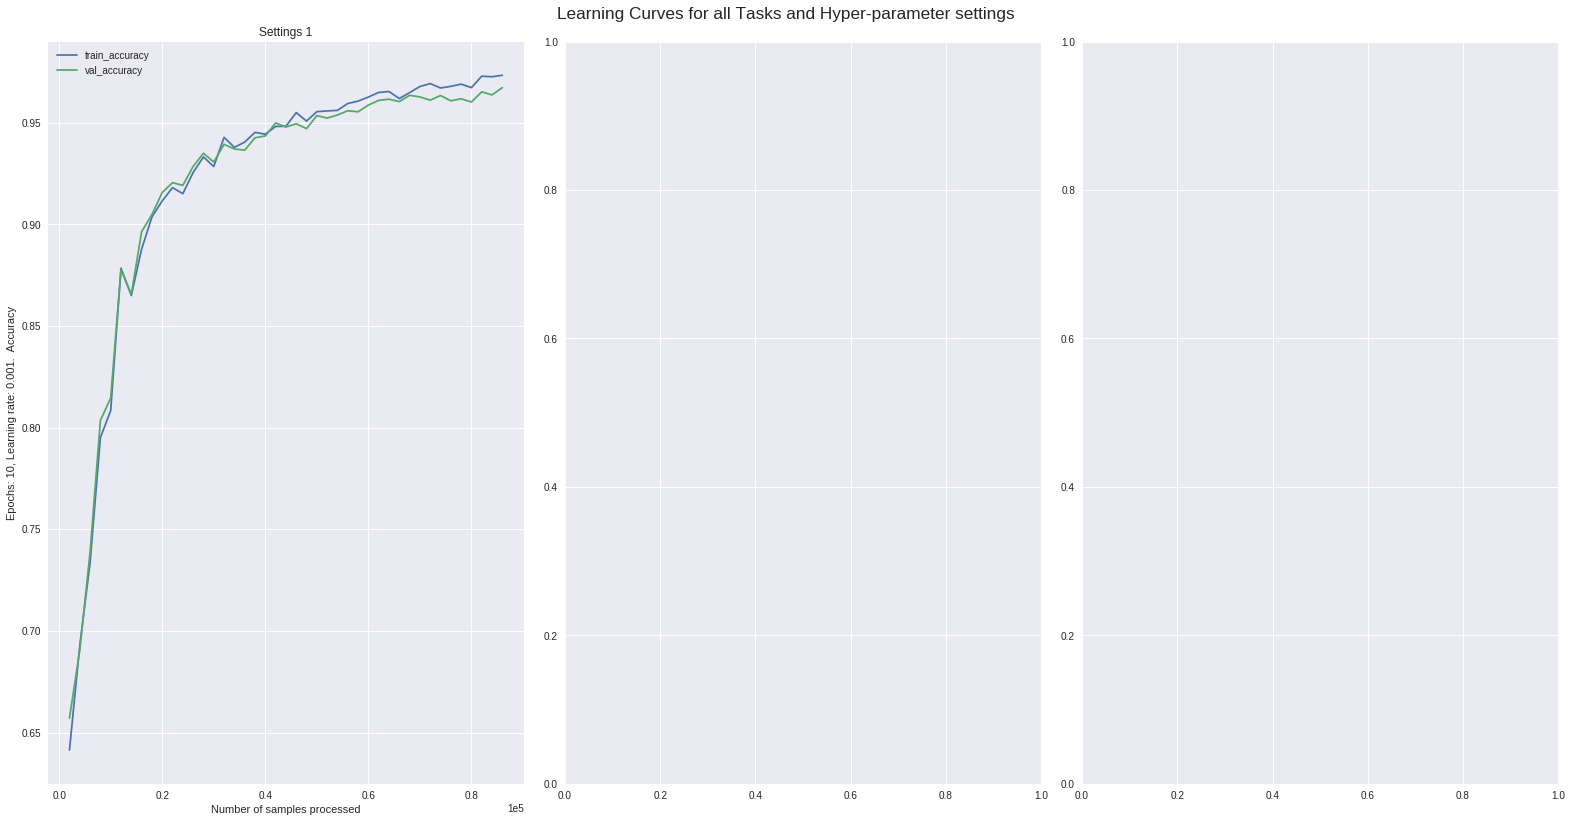

In [228]:
plot_learning_curves(experiments_task1)

# Restore test

In [0]:
num_epochs=1
learning_rate=0.001
mnist = get_data()
eval_mnist = get_data()

In [239]:
tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "./model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  batch_xs, batch_ys = mnist.train.next_batch((int(mnist.train.labels.shape[0]/5)))
  feed_dict={x:batch_xs,y_:batch_ys}
  acc=sess.run([accuracy],feed_dict)
  print(f'{tf.trainable_variables()}')
  total_parameters=0
  restore_var_list=[]
  for variable in tf.trainable_variables():
    restore_var_list.append(variable)
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
  print("total parameters",total_parameters)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
[<tf.Variable 'weight_0:0' shape=(784, 1000) dtype=float32_ref>, <tf.Variable 'weight_1:0' shape=(1000, 1000) dtype=float32_ref>, <tf.Variable 'weight_2:0' shape=(1000, 500) dtype=float32_ref>, <tf.Variable 'weight_3:0' shape=(500, 200) dtype=float32_ref>, <tf.Variable 'weight_4:0' shape=(200, 10) dtype=float32_ref>]
total parameters 2386000


# Pruning

Unit pruning - Han, S., Pool, J., Tran, J. and Dally, W., 2015. Learning both weights and connections for efficient neural network. In Advances in neural information processing systems (pp. 1135-1143).

Weight pruning - LeCun, Y., Denker, J.S. and Solla, S.A., 1990. Optimal brain damage. In Advances in neural information processing systems (pp. 598-605).

In [0]:
k=[25, 50, 60, 70, 80, 90, 95, 97, 99]
type_prunes=['weight','unit']
# type_prunes=['weight'] #redo weight

In [0]:
import time

## Pruning withouth fine-tuning

In [252]:
#pruning without re-training 

num_epochs=1
tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs=[]
params=[]
avg_inference_times=[]
with tf.Session() as sess:
  param_prune_count=[]
  acc_list=[]

# Restore variables from disk.
  saver.restore(sess, "./model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  all_vars =[]
  var_sizes=[]
  mask_vars=[]
   
  for variable in tf.trainable_variables():
    if 'weight' in variable.name and str(len(layers)-1) not in variable.name:
      var_sizes.append(variable.shape)
      all_vars.append(variable)
      
  for variable in tf.global_variables():
    if 'mask' in variable.name and str(len(layers)-1) not in variable.name:
      mask_vars.append(variable)
  for type_prune in type_prunes:
    params_pruned=0.
    mask1=np.ones(var_sizes[0])*1.0
    mask2=np.ones(var_sizes[1])*1.0
    mask3=np.ones(var_sizes[2])*1.0
    mask4=np.ones(var_sizes[3])*1.0
    k=1
    if type_prune=='unit':
      batch_k=25 #how many columns to prune per each prune iteration
      axis_sum=0
    else: 
      batch_k=23860 #how many weights at a time 
      axis_sum=1
      
    #Prune measures used to rank unit/ weights: l2 norm for unit and l1 for weight. 

    
    #0) Compute Ranks, as we do not fine-tune this can be pre-computed
      
    var_mag=np.array([])
    layer_sizes=[]
    for var_num,variable in enumerate(all_vars):
      if type_prune=='unit':
        layer_sizes.append(variable.shape[1].value)
        unit_vals=(tf.norm(variable,axis=axis_sum).eval())
        var_mag=np.concatenate((var_mag,unit_vals),axis=0)
      else: 
        layer_sizes.append(variable.shape[0].value*variable.shape[1].value) #each individual weight
        weight_vals=tf.reshape(tf.math.abs(variable),[-1]).eval()
        var_mag=np.concatenate((var_mag,weight_vals),axis=0)

    cum_sum_ind=np.cumsum(layer_sizes)        
    all_concat=np.reshape(np.array(var_mag),((-1,)))
    all_concat=np.sort(all_concat)
    while (params_pruned/total_parameters)<=0.99: #do 99% of pruning 
      sparse_before=int((k-1)*batch_k)
      partion_k=int(batch_k*k)
      
      if type_prune=='unit':
        axis_sum=0 #add on abs of bias's 
      else: 
        axis_sum=1
        
      #1) Evaluate 
      
      feed_dict={x:eval_mnist.test.images,y_:eval_mnist.test.labels}
      t_before=time.time()
      acc=sess.run(accuracy,feed_dict)
      t_after=time.time()
      avg_inference_times.append(t_after-t_before)

      param_prune_count.append(params_pruned/total_parameters)
      acc_list.append(acc)
      print(f"paramns pruned {params_pruned}, k={params_pruned/total_parameters*1.0} sparsity level and acc is {acc}")
      
      prune_indxss=all_concat[sparse_before:partion_k] #first k guaranteed to be the lowest index's      
      prune_indxs=np.array([np.where(all_concat==i)[0][0] for i in prune_indxss])     
      
      #2) Pruning
      
      ly1=prune_indxs[~(prune_indxs>=cum_sum_ind[0])]  
      prune_indxs=prune_indxs[~(prune_indxs<cum_sum_ind[0])]   
      ly2=prune_indxs[~(prune_indxs>=cum_sum_ind[1])]  
      prune_indxs=prune_indxs[~(prune_indxs<cum_sum_ind[1])]   
      ly3=prune_indxs[~(prune_indxs>=cum_sum_ind[2])]  
      prune_indxs=prune_indxs[~(prune_indxs<cum_sum_ind[2])]   
      ly4=prune_indxs[~(prune_indxs>=cum_sum_ind[3])]  
     
      
      ly2=ly2-cum_sum_ind[0]
      ly3=ly3-cum_sum_ind[1]
      ly4=ly4-cum_sum_ind[2]
      
      if type_prune=='unit':        
        mask1[:,ly1]=0
        mask2[:,ly2]=0
        mask3[:,ly3]=0
        mask4[:,ly4]=0
        params_pruned+=ly1.shape[0]*(all_vars[0].shape[0].value)+ly2.shape[0]*(all_vars[1].shape[0].value)+ly3.shape[0]*(all_vars[2].shape[0].value)+ly4.shape[0]*(all_vars[3].shape[0].value)
      
      else:        
        i_idx1=(ly1/var_sizes[0][1].value).astype(int)
        j_idx1=(ly1 % var_sizes[0][1].value).astype(int)       
        i_idx2=(ly2/var_sizes[1][1].value).astype(int)
        j_idx2=(ly2 % var_sizes[1][1].value).astype(int) 
        i_idx3=(ly3/var_sizes[2][1].value).astype(int)
        j_idx3=(ly3 % var_sizes[2][1].value).astype(int)
        i_idx4=(ly4/var_sizes[3][1].value).astype(int)
        j_idx4=(ly4 % var_sizes[3][1].value).astype(int)
        
        mask1[i_idx1,j_idx1]=0
        mask2[i_idx2,j_idx2]=0
        mask3[i_idx3,j_idx3]=0
        mask4[i_idx4,j_idx4]=0
        
        params_pruned+=batch_k

      assign_op=[mask_vars[0].assign(mask1)] #updates pruning masks. 
      assign_op+=[mask_vars[1].assign(mask2)]
      assign_op+=[mask_vars[2].assign(mask3)]
      assign_op+=[mask_vars[3].assign(mask4)]

      sess.run(assign_op)
   
      k+=1     

    print(acc_list,"acc list")
    print(param_prune_count,"param_prune_count list")
    print(type_prune,"type_prune is")

    accs.append(acc_list)
    params.append(param_prune_count)
    
    print(f'average inf time {np.mean(np.array(avg_inference_times))}')
  save_path = saver.save(sess, "./model_sparse.ckpt")

2386000 Total parameters to prune
INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
paramns pruned 0.0, k=0.0 sparsity level and acc is 0.9672999978065491


KeyboardInterrupt: ignored

## Pruning with fine-tuning

In [235]:
#pruning with re-training 

num_epochs=1
tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs=[]
params=[]

with tf.Session() as sess:
  params_pruned=0.
  param_prune_count=[]
  acc_list=[]

# Restore variables from disk.
  saver.restore(sess, "./model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  all_vars =[]
  var_sizes=[]
  mask_vars=[]
   
  for variable in tf.trainable_variables():
    if 'weight' in variable.name and str(len(layers)-1) not in variable.name:
      var_sizes.append(variable.shape)
      all_vars.append(variable)
      
  for variable in tf.global_variables():
    if 'mask' in variable.name and str(len(layers)-1) not in variable.name:
      mask_vars.append(variable)
  for type_prune in type_prunes:
    mask1=np.ones(var_sizes[0])*1.0
    mask2=np.ones(var_sizes[1])*1.0
    mask3=np.ones(var_sizes[2])*1.0
    mask4=np.ones(var_sizes[3])*1.0
    k=1
    if type_prune=='unit':
      batch_k=25 #how many columns to prune per each prune iteration
      axis_sum=0
    else: 
      batch_k=23860 #how many weights at a time 
      axis_sum=1
      
    #Prune measures used to rank unit/ weights: l2 norm for unit and l1 for weight. 
    already_pruned=np.array([]).astype(int)
    while k<(int(total_parameters/batch_k)-1): 
      sparse_before=int((k-1)*batch_k)
      partion_k=int(batch_k*k)
      
      if type_prune=='unit':
        axis_sum=0 #add on abs of bias's 
      else: 
        axis_sum=1
        
      #1) Evaluate 
      
      feed_dict={x:eval_mnist.test.images,y_:eval_mnist.test.labels}
      acc=sess.run(accuracy,feed_dict)
      param_prune_count.append(params_pruned)
      acc_list.append(acc)
      print(f"paramns pruned {params_pruned}, k={params_pruned/total_parameters*1.0} sparsity level and acc is {acc}")
      
      #2) Compute Ranks
      
      var_mag=np.array([])
      layer_sizes=[]
      for var_num,variable in enumerate(all_vars):
        if type_prune=='unit':
          layer_sizes.append(variable.shape[1].value)
          unit_vals=(tf.norm(variable,axis=axis_sum).eval())
          var_mag=np.concatenate((var_mag,unit_vals),axis=0)
        else: 
          layer_sizes.append(variable.shape[0].value*variable.shape[1].value) #each individual weight
          weight_vals=tf.reshape(tf.math.abs(variable),[-1]).eval()
          var_mag=np.concatenate((var_mag,weight_vals),axis=0)

      cum_sum_ind=np.cumsum(layer_sizes)        
      all_concat=np.reshape(np.array(var_mag),((-1,)))
      if sparse_before>0:
        all_concat[already_pruned]=0
      prune_indxss=np.sort(all_concat)[sparse_before:partion_k] #first k guaranteed to be the lowest index's      
      prune_indxs=np.array([np.where(all_concat==i)[0][0] for i in prune_indxss])     
      prune_indxs=np.setdiff1d(prune_indxs,already_pruned)
      already_pruned=np.concatenate((already_pruned,prune_indxs)) #save pruned indx
      prune_indxs=np.sort(prune_indxs)
      
      #3) Pruning
      
      ly1=prune_indxs[~(prune_indxs>=cum_sum_ind[0])]  
      prune_indxs=prune_indxs[~(prune_indxs<cum_sum_ind[0])]   
      ly2=prune_indxs[~(prune_indxs>=cum_sum_ind[1])]  
      prune_indxs=prune_indxs[~(prune_indxs<cum_sum_ind[1])]   
      ly3=prune_indxs[~(prune_indxs>=cum_sum_ind[2])]  
      prune_indxs=prune_indxs[~(prune_indxs<cum_sum_ind[2])]   
      ly4=prune_indxs[~(prune_indxs>=cum_sum_ind[3])]  
     
      
      ly2=ly2-cum_sum_ind[0]
      ly3=ly3-cum_sum_ind[1]
      ly4=ly4-cum_sum_ind[2]
      
      if type_prune=='unit':        
        mask1[:,ly1]=0
        mask2[:,ly2]=0
        mask3[:,ly3]=0
        mask4[:,ly4]=0
        params_pruned+=ly1.shape[0]*(all_vars[0].shape[0].value)+ly2.shape[0]*(all_vars[1].shape[0].value)+ly3.shape[0]*(all_vars[2].shape[0].value)+ly4.shape[0]*(all_vars[3].shape[0].value)
      
      else:        
        i_idx1=(ly1/var_sizes[0][1].value).astype(int)
        j_idx1=(ly1 % var_sizes[0][1].value).astype(int)       
        i_idx2=(ly2/var_sizes[1][1].value).astype(int)
        j_idx2=(ly2 % var_sizes[1][1].value).astype(int) 
        i_idx3=(ly3/var_sizes[2][1].value).astype(int)
        j_idx3=(ly3 % var_sizes[2][1].value).astype(int)
        i_idx4=(ly4/var_sizes[3][1].value).astype(int)
        j_idx4=(ly4 % var_sizes[3][1].value).astype(int)
        
        mask1[i_idx1,j_idx1]=0
        mask2[i_idx2,j_idx2]=0
        mask3[i_idx3,j_idx3]=0
        mask4[i_idx4,j_idx4]=0
        
        params_pruned+=batch_k

      assign_op=[mask_vars[0].assign(mask1)] #updates pruning masks. 
      assign_op+=[mask_vars[1].assign(mask2)]
      assign_op+=[mask_vars[2].assign(mask3)]
      assign_op+=[mask_vars[3].assign(mask4)]

      sess.run(assign_op)
   
      k+=1
      
      #4) Train for one epoch
      
      mnist.train._epochs_completed = 0
      mnist.train._index_in_epoch = 0
      while mnist.train.epochs_completed < num_epochs:

        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict={x:batch_xs,y_:batch_ys}
        _=sess.run([opt],feed_dict=feed_dict)
      
#run at end to finalise variables       
      
      

    print(acc_list,"acc list")
    print(param_prune_count,"param_prune_count list")
    print(type_prune,"type_prune is")

    accs.append(acc_list)
    params.append(param_prune_count)

2386000 Total parameters to prune
INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
paramns pruned 0.0, k=0.0 sparsity level and acc is 0.9672999978065491
paramns pruned 19600.0, k=0.008214585079631182 sparsity level and acc is 0.9711999893188477
paramns pruned 38416.0, k=0.016100586756077118 sparsity level and acc is 0.9781000018119812
paramns pruned 58016.0, k=0.024315171835708298 sparsity level and acc is 0.9765999913215637
paramns pruned 77616.0, k=0.03252975691533948 sparsity level and acc is 0.9775999784469604
paramns pruned 97648.0, k=0.040925398155909475 sparsity level and acc is 0.98089998960495
paramns pruned 118112.0, k=0.049502095557418274 sparsity level and acc is 0.9811999797821045
paramns pruned 139872.0, k=0.0586219614417435 sparsity level and acc is 0.9807999730110168
paramns pruned 162280.0, k=0.06801341156747695 sparsity level and acc is 0.9807000160217285
paramns pruned 184256.0, k=0.07722380553227158 sparsity level and acc is 0.9783999919891357

KeyboardInterrupt: ignored

# Bonus

In [0]:
tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
saver = tf.train.Saver()
print(total_parameters, "Total parameters to prune")
accs=[]
params=[]

with tf.Session() as sess:
  params_pruned=0.
  param_prune_count=[]
  acc_list=[]

# Restore variables from disk.
  saver.restore(sess, "./model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  all_vars =[]
  var_sizes=[]
  mask_vars=[]
   
  for variable in tf.trainable_variables():
    if 'weight' in variable.name and str(len(layers)-1) not in variable.name:
      var_sizes.append(variable.shape)
      all_vars.append(variable)
      
  for variable in tf.global_variables():
    if 'mask' in variable.name and str(len(layers)-1) not in variable.name:
      mask_vars.append(variable)
      
  

# Analysis

In [0]:
# plot cumsum of params prunes against accuracy 
# maybe 